In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc, os, sys
gc.collect()

dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC,generate_representation
from evaluation import calculate_metrics, evaluate_metadata, evaluate_metadata_raw

    
folder = "../../KOI_Data/"
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"

Using TensorFlow backend.


In [2]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values


df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
0,K00889.01,CONFIRMED,Kepler-75 b,8.884923,169.991686,2455002.992,0.069,2.07004,16053.4,0.114,...,5332.0,4.500,-0.08,0.843,0.821,61.291,474.021,388.2,1,153
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.535940,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
7,K07622.01,FALSE POSITIVE,NaN,36.267167,155.081300,2454988.081,0.214,2.06500,627.1,0.022,...,4264.0,4.637,-0.20,0.620,0.607,3.016,7.472,10.0,1,39
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.039000,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9
10,K00992.01,CONFIRMED,Kepler-745 b,9.931463,136.491280,2454969.491,0.037,5.67800,398.6,0.018,...,5782.0,4.280,0.16,1.220,1.035,4.530,22.901,26.2,2,137


In [3]:
## load mtfs
n_up = 16
n_down = 32

folder = "/work/work_teamEXOPLANET/"
MTF_data = np.load(folder+'/MTF_margarita/no_invertidos/MTF_u%d_d%d.npy'%(n_up,n_down))  
TIME_data = np.load(folder+'/MTF_gabo/npys/MTF_time_u%d_d%d.npy'%(n_up,n_down))  

x_all = []
for i in range(MTF_data.shape[0]):
    combined_image = np.dstack((MTF_data[i],TIME_data[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

from code_MTF import det_state_2ways, det_celda
S_grid = det_state_2ways(1,-1, n_sta_up=n_up, n_sta_low=n_down) 

x_all.shape

(8054, 48, 48, 2)

In [4]:
## load light curves

time_kepler = np.load(folder_lc+"npy/KOI_LC_time.npy")
process_lc = np.load(folder_lc+'/cleaned/LC_kepler_processed.npy')
N, T = time_kepler.shape
print((N,T))

(8054, 71427)


In [5]:
#borrar nans... arreglo variable
coupled_lc = []
coupled_time = []
for i in range(N):
    mask_nan = np.isnan(process_lc[i])
    
    coupled_lc.append(process_lc[i][~mask_nan])
    coupled_time.append(time_kepler[i][~mask_nan])    
    
coupled_lc = np.asarray(coupled_lc)
coupled_time = np.asarray(coupled_time)

def prepare_lc(fluxs): #dividir por min
    fluxs = np.asarray(fluxs)
    return fluxs/np.abs(np.nanmin(fluxs))

In [34]:
from numba import njit
@njit(parallel=False, cache=True, fastmath=True)  #no se pudo paralelizar por el acceso a lista "ind -1"
def evaluate_MTF(x_l, s_l, Matrix, S_grid, delta_M=0.03125):
    T_l = len(x_l)
    
    prob_ev = []
    for t in range(T_l-1):
        delta = s_l[t+1] - s_l[t]
        #if delta <= delta_M:
        i = det_celda(x_l[t], S_grid)
        j = det_celda(x_l[t+1], S_grid)
        prob_ev.append(Matrix[i,j])
        #else:
        #    prob_ev.append(np.nan) #-1)
        
    return np.asarray(prob_ev)

from code_MTF import build_MTF

M = build_MTF(fluxs, coupled_time[i], n_up = 16, n_down=32, delta_M = 0.03125)
M

array([[0.02083333, 0.02083333, 0.02083333, ..., 0.02083333, 0.02083333,
        0.02083333],
       [0.02083333, 0.02083333, 0.02083333, ..., 0.02083333, 0.02083333,
        0.02083333],
       [0.02083333, 0.02083333, 0.02083333, ..., 0.02083333, 0.02083333,
        0.02083333],
       ...,
       [0.02083333, 0.02083333, 0.02083333, ..., 0.02083333, 0.02083333,
        0.02083333],
       [0.02083333, 0.02083333, 0.02083333, ..., 0.02083333, 0.02083333,
        0.02083333],
       [0.02      , 0.02      , 0.02      , ..., 0.02      , 0.02      ,
        0.02      ]])

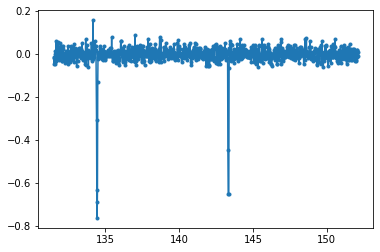

<ipython-input-6-4236f563a919>:10: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'estados' of function 'det_celda'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "code_MTF.py", line 24:
@njit(parallel=False, cache=True, fastmath=False)
def det_celda(num, estados): 
^

  i = det_celda(x_l[t], S_grid)
/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:1958: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'S_grid' of function 'evaluate_MTF'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-6-4236f563a919>", line 3:
@njit(parallel=False, cache=True, fastmath=Tr

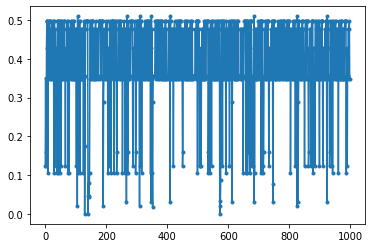

In [7]:
fluxs = prepare_lc(coupled_lc[0]) #divide by min

stop = 1000

plt.plot(coupled_time[0][:stop], fluxs[:stop] ,".-")
plt.show()

v = evaluate_MTF(fluxs[:stop], coupled_time[0][:stop], MTF_data[0], S_grid)
plt.plot(v, ".-")
plt.show()

In [8]:
def get_semi_cont(x_l, s_l, S_grid, delta_M=0.03125):
    x_return = []
    s_return = []
    
    for t in range( len(x_l)):
        if t ==0:
            aux_x = [x_l[t]]
            aux_s = [s_l[t]]
        else:
            delta = s_l[t] - s_l[t-1]
            if delta <= delta_M:
                aux_x.append(x_l[t])
                aux_s.append(s_l[t])
            else:
                x_return.append(aux_x)
                s_return.append(aux_s)
                aux_x = []
                aux_s = []
    return x_return, s_return

def find_wind(f, t, MTF, S_grid, less=True, K=10):
    prob_w = []
    for f_w, t_w in zip(f, t):
        if len(f_w) > 3: # a minimum value
            v = evaluate_MTF(f_w, t_w, MTF, S_grid)
            prob_w.append(np.sum(np.log(v)))
            #prob_w.append(np.sum(v))
        else:
            prob_w.append(np.nan)
            
    NAN_l = np.sum(np.isnan(prob_w))
    if less:
        return np.argsort(prob_w)[:K] #less probably that happens
    else:
        return np.argsort(prob_w)[::-1][NAN_l:K+NAN_l] #most probably that happens    

In [ ]:
i = 0

fluxs = prepare_lc(coupled_lc[i]) #divide by min

fluxs_w, time_w = get_semi_cont(fluxs, coupled_time[i], S_grid)
idx_mins = find_wind(fluxs_w, time_w, MTF_data[i], S_grid, less=False)

for idx_min in idx_mins:
    plt.plot(time_w[idx_min], fluxs_w[idx_min])
    plt.show()

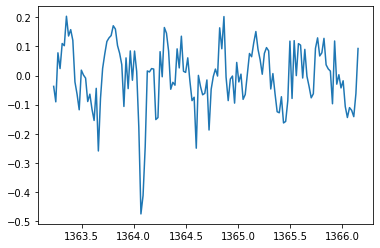

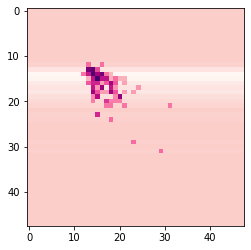

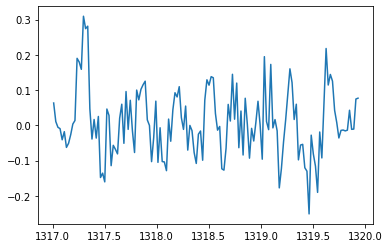

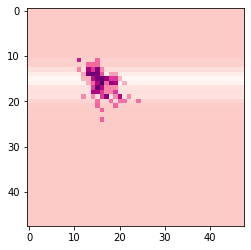

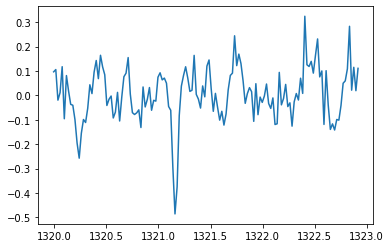

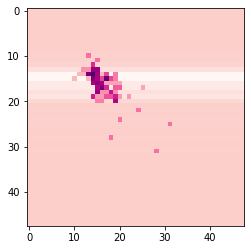

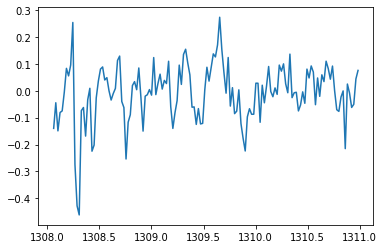

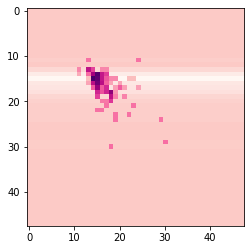

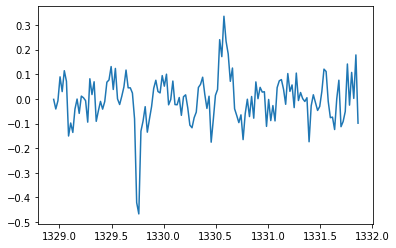

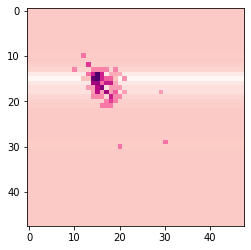

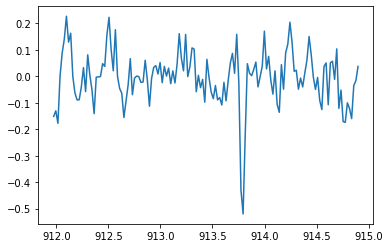

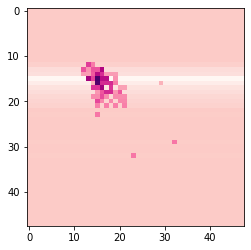

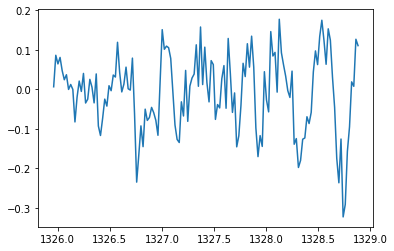

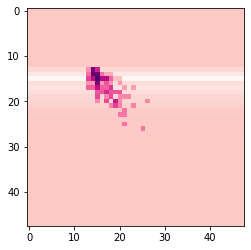

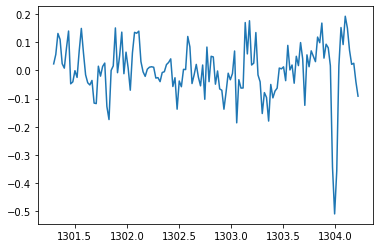

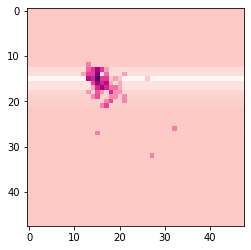

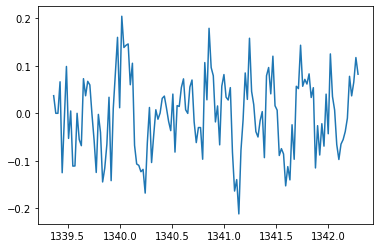

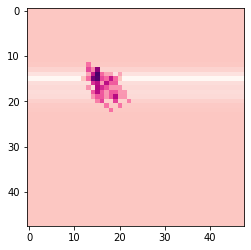

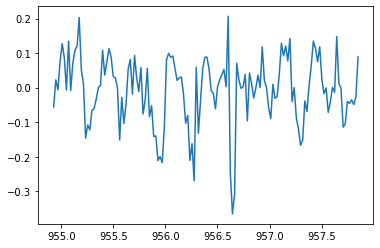

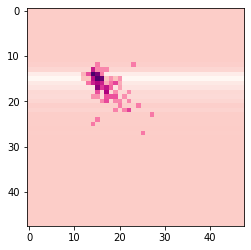

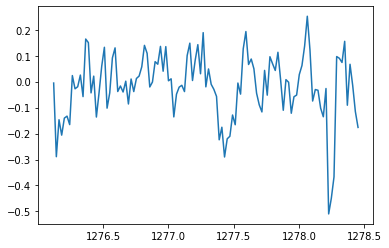

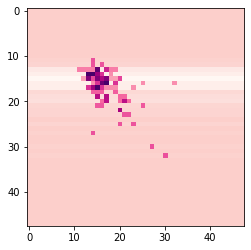

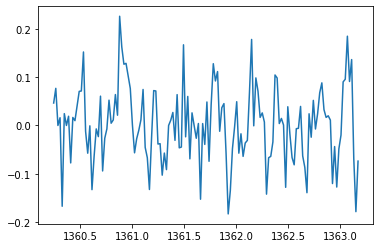

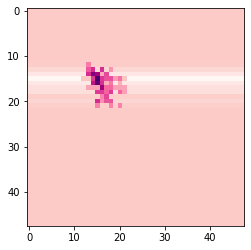

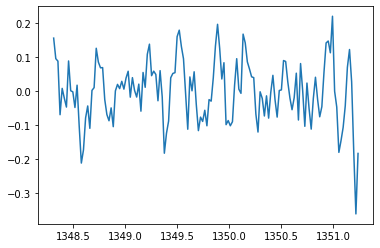

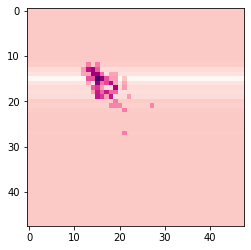

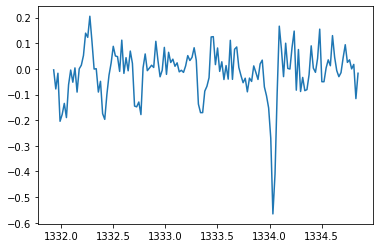

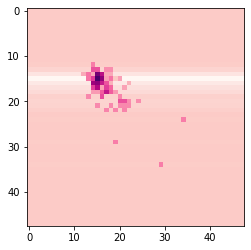

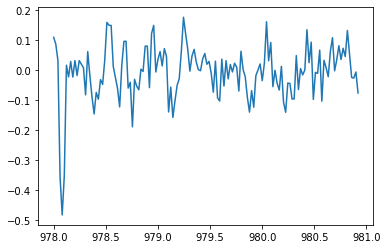

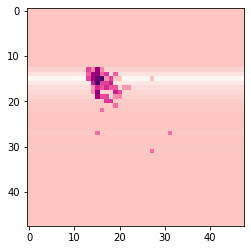

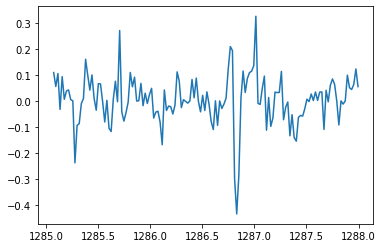

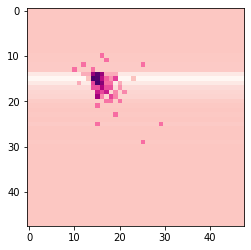

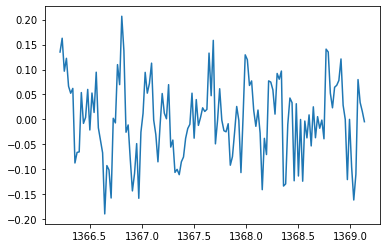

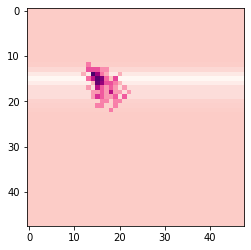

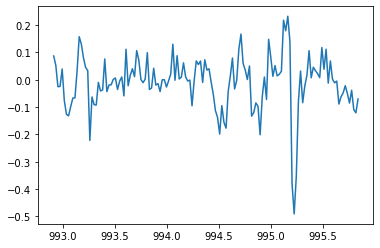

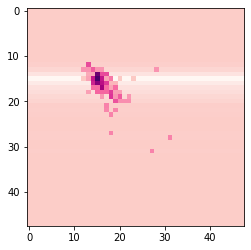

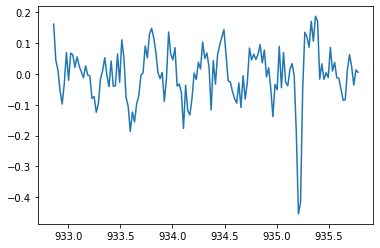

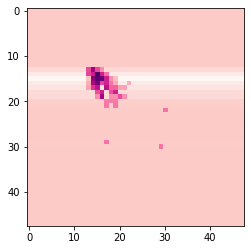

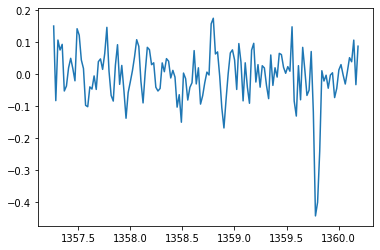

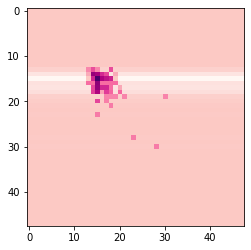

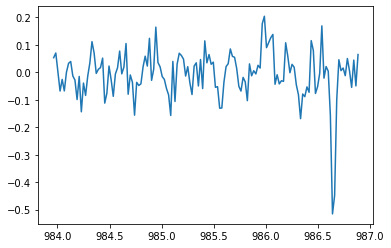

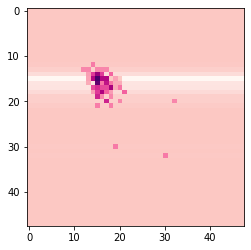

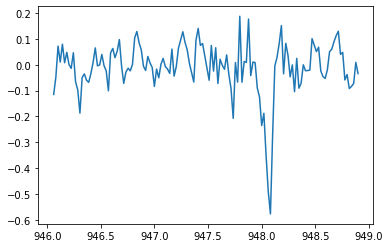

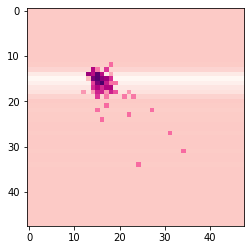

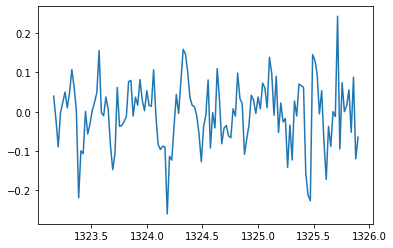

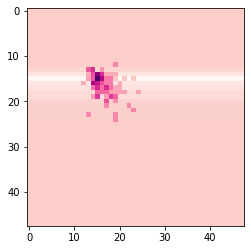

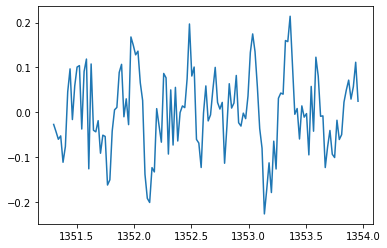

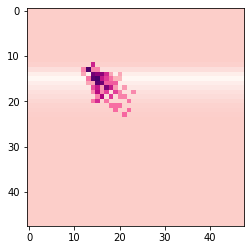

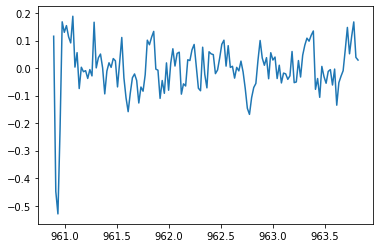

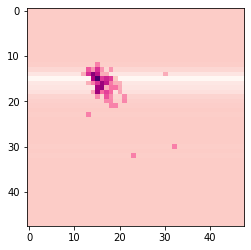

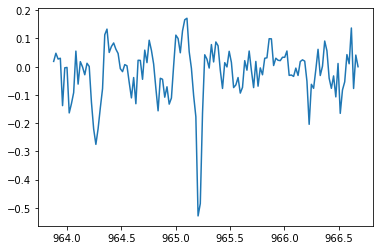

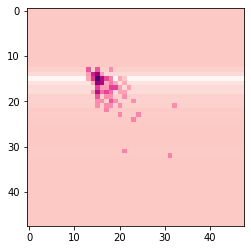

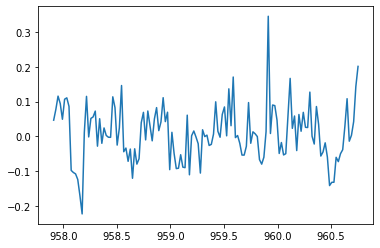

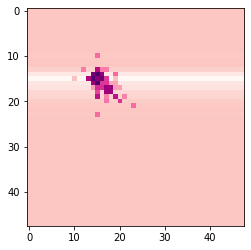

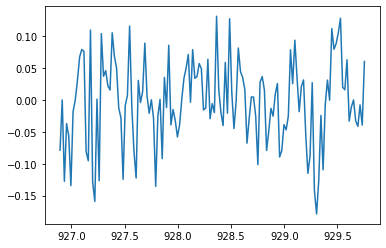

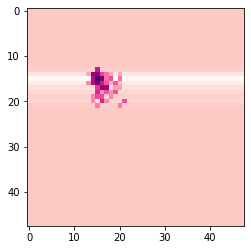

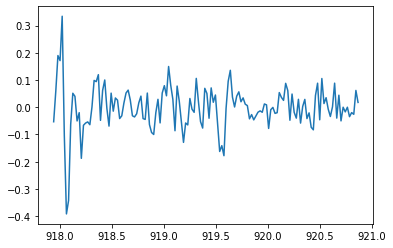

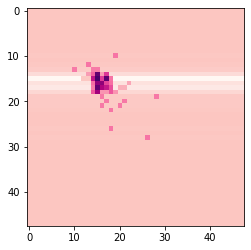

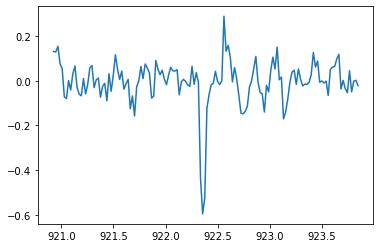

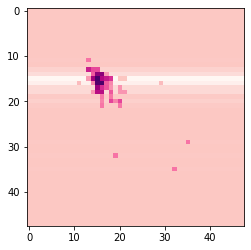

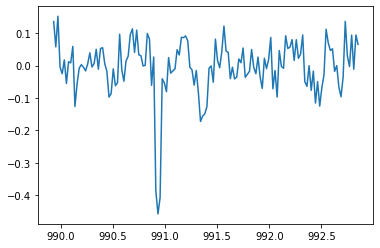

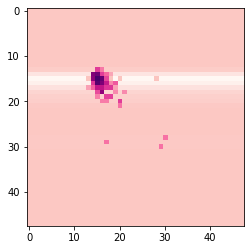

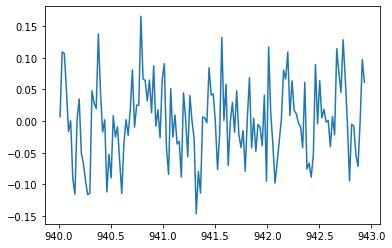

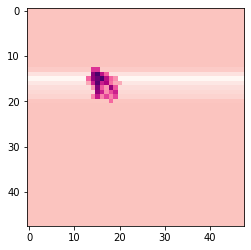

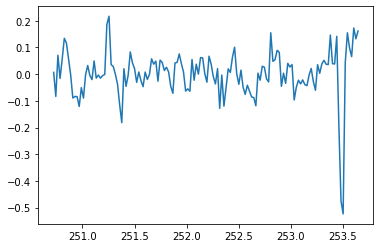

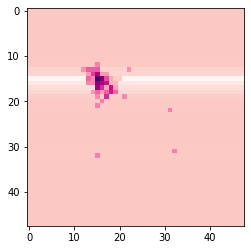

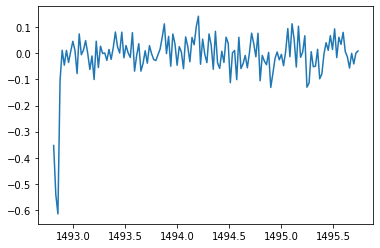

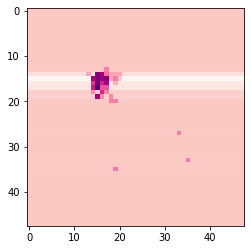

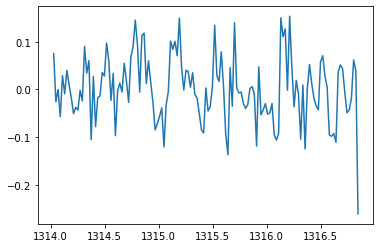

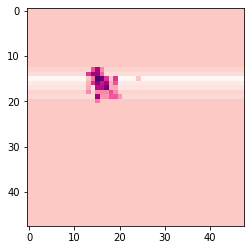

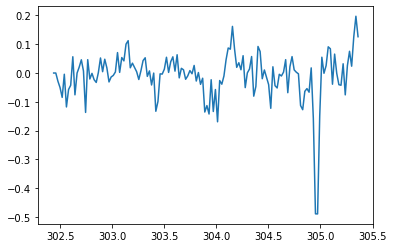

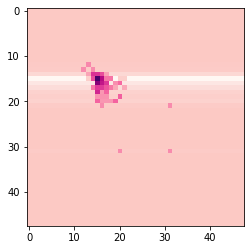

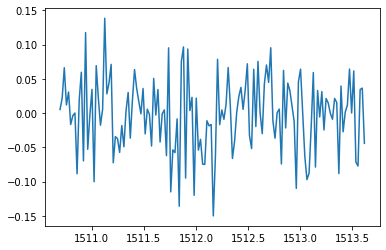

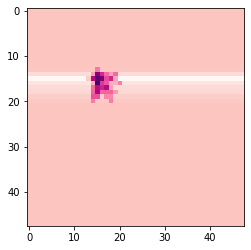

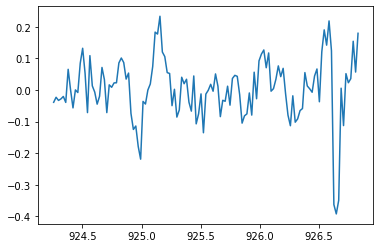

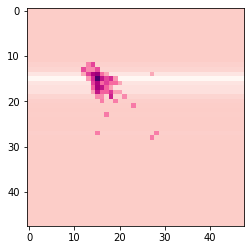

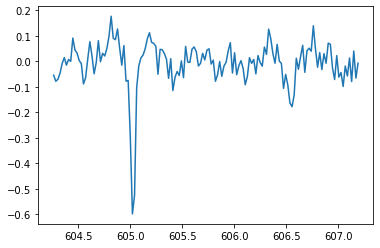

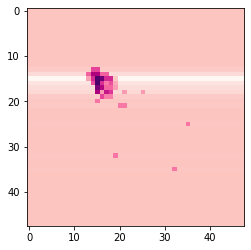

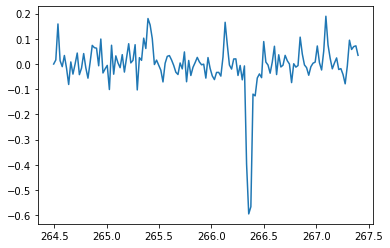

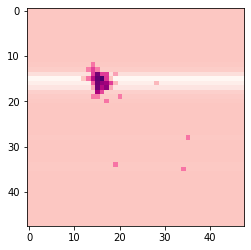

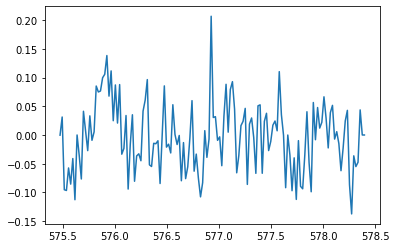

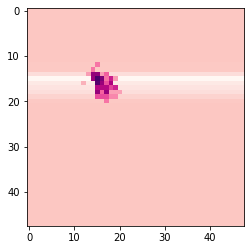

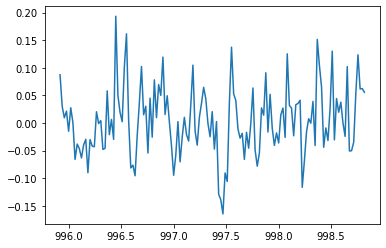

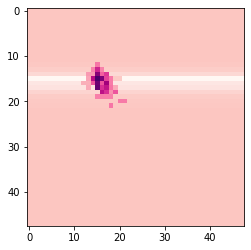

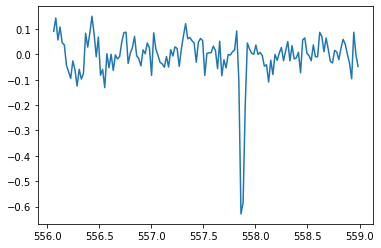

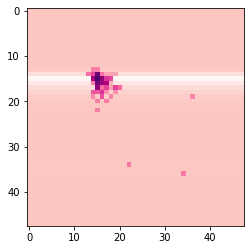

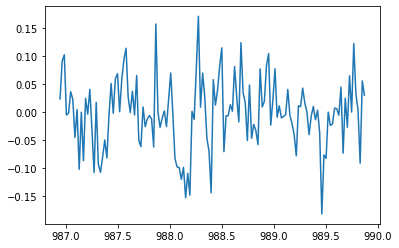

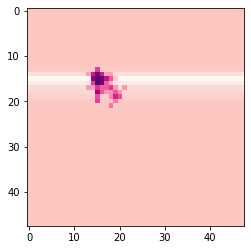

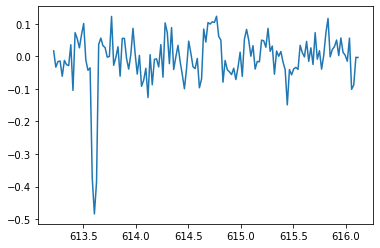

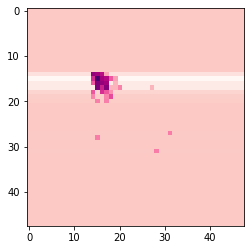

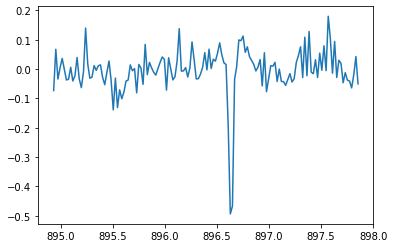

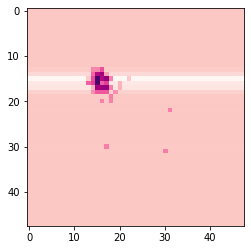

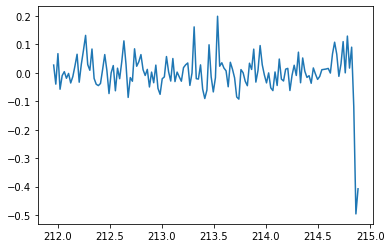

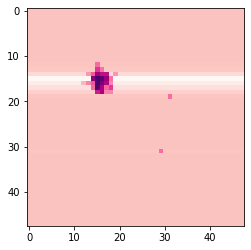

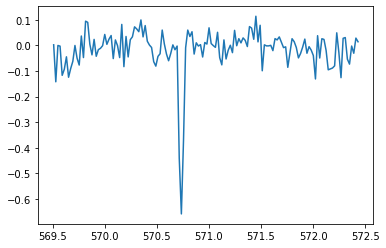

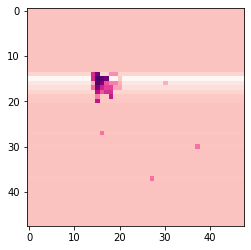

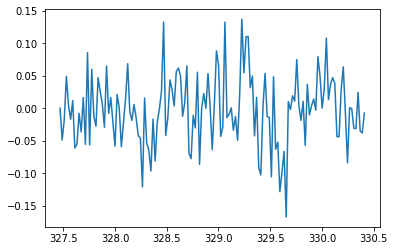

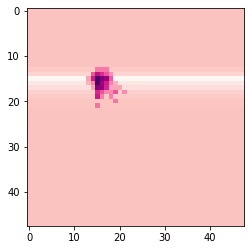

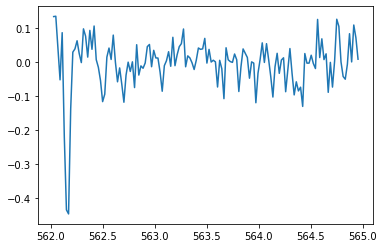

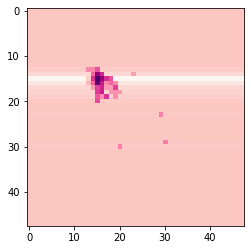

In [32]:
i = 5

fluxs = prepare_lc(coupled_lc[i]) #divide by min

fluxs_w, time_w = get_semi_cont(fluxs, coupled_time[i], S_grid)
idx_mins = find_wind(fluxs_w, time_w, MTF_data[i], S_grid, less=True, K=50)

for idx_min in idx_mins:
    plt.plot(time_w[idx_min], fluxs_w[idx_min])
    plt.show()
    
    #v = evaluate_MTF(fluxs_w[idx_min], time_w[idx_min], MTF_data[i], S_grid)
    #plt.plot(v)
    #plt.show()
    
    M = build_MTF(fluxs_w[idx_min], time_w[idx_min], n_up = 16, n_down=32)
    plt.imshow(M, cmap='RdPu', norm=LogNorm())
    plt.show()

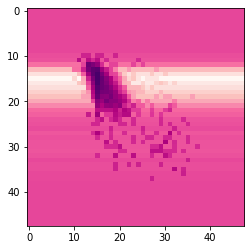

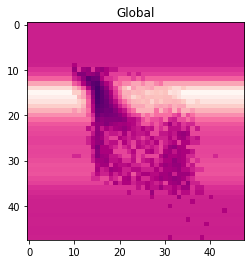

In [33]:
M_aux = 0
for idx_min in idx_mins:
    M_aux += build_MTF(fluxs_w[idx_min], time_w[idx_min], n_up = 16, n_down=32, norm=False)

M_aux += 1
M_aux = M_aux/ M_aux.sum(axis=1, keepdims=True) #normalize
plt.imshow(M_aux, cmap='RdPu', norm=LogNorm())
plt.show()

plt.imshow(MTF_data[i], cmap='RdPu', norm=LogNorm())
plt.title("Global")
plt.show()
